In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.base import TransformerMixin
from custom_transformer import TransformTimekey
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import clone
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import json
import joblib
import pickle

# 0. Get the data

In [2]:
df_product_prices_raw = pd.read_csv(os.path.join("..", "data", "product_prices_leaflets.csv"))

In [3]:
df_prod_structure_sales_raw = pd.read_csv(os.path.join("..", "data", "product_structures_sales.csv"))

In [4]:
df_test_raw = pd.read_csv(os.path.join("..", "data", "capstone_prod_dump_20250601.csv"))

# 1. Treat the data

Notes:
* It has been checked that there are no missing days overall
* Since there is a weekly seasonality, a rolling window of seven days might gives insights on characteristics of each week
* the Target is price_final, sales price after applying the discount

Removing unnecessary columns from training data and creating the target (sales price). This only applies to the training data.

In [5]:
# this only need to be done to the training data
def treat_prices(df_raw):
    df = df_raw.copy()
    df = df[df.discount >= 0]
    df['price_final'] = df['pvp_was'] * (1 - df['discount'])
    # removing leaflet "creates" duplicates -> need to drop them
    df = df.drop(columns=['pvp_was', 'discount', 'flag_promo', 'leaflet']).drop_duplicates()
    return df

In [6]:
df_product_prices = treat_prices(df_product_prices_raw)

Treating time_key and extracting other time-related features. This will be made to time_key input so we need a Customer Transformer.

In [7]:
# this will have to be made to user input as well, so it will go to a Custom Transformer
def treat_timekeys(df_raw):
    df = df_raw.copy()
    df['time_key'] = pd.to_datetime(df['time_key'], format='%Y%m%d')
    df['year'] = df['time_key'].apply(lambda row: row.year)
    df['month'] = df['time_key'].apply(lambda row: row.month)
    df['day'] = df['time_key'].apply(lambda row: row.day)
    df['weekday'] = df['time_key'].apply(lambda row: row.weekday())
    df['is_weekend'] = df['weekday'].apply(lambda row: row in (5, 6))
    df['sin_weekday'] = np.sin(2*np.pi*df['weekday']/7)
    df = df.drop(columns='time_key')
    return df

In [8]:
df_product_prices_timetreated = df_product_prices.copy()
df_product_prices_timetreated = treat_timekeys(df_product_prices_timetreated)
df_product_prices_timetreated.head()

,sku,competitor,price_final,year,month,day,weekday,is_weekend,sin_weekday
0,2056,chain,21.700000,2024,3,12,1,False,0.781831
1,4435,chain,13.709432,2023,6,21,2,False,0.974928
2,1951,competitorA,39.231608,2023,3,3,4,False,-0.433884
3,2135,chain,41.477667,2024,6,5,2,False,0.974928
4,3949,chain,51.900000,2023,5,29,0,False,0.000000


In [9]:
"""class TransformTimekey(TransformerMixin):   
    def transform(self, X_original, *_):
        X = X_original.copy()
        X['time_key'] = pd.to_datetime(X['time_key'], format='%Y%m%d')
        X['year'] = X['time_key'].apply(lambda row: row.year)
        X['month'] = X['time_key'].apply(lambda row: row.month)
        X['day'] = X['time_key'].apply(lambda row: row.day)
        X['weekday'] = X['time_key'].apply(lambda row: row.weekday())
        X['is_weekend'] = X['weekday'].apply(lambda row: row in (5, 6))
        X['sin_weekday'] = np.sin(2*np.pi*X['weekday']/7)
        X = X.drop(columns='time_key')
        return X
    
    def fit(self, *_):
        return self""";

Product structure is a static information, retrieving it and storing it in a CSV for later use.

In [10]:
def treat_prod_structure_sales(df_raw):
    df = df_raw.copy()
    df = df[df.quantity >= 0]
    df['time_key'] = pd.to_datetime(df['time_key'], format='%Y%m%d')
    return df

In [11]:
df_prod_structure_sales = treat_prod_structure_sales(df_prod_structure_sales_raw)

In [12]:
def create_product_structure(df_raw):
    df = df_raw.copy()
    df = df.drop(columns=['time_key', 'quantity']).drop_duplicates()
    df = df.set_index('sku')
    return df

In [13]:
df_product_structure = create_product_structure(df_prod_structure_sales)

In [14]:
df_product_structure.to_csv("product_structures.csv")

Create the potential training dataset by merging - later in the app, the used structure level can be retrieved from the CSV.

In [15]:
df_prod_struct_prices = df_product_prices.merge(df_product_structure, left_on='sku', right_index=True)
df_prod_struct_prices = df_prod_struct_prices.sort_values(by='time_key')

In [16]:
df_prod_struct_prices.head()

,sku,time_key,competitor,price_final,structure_level_4,structure_level_3,structure_level_2,structure_level_1
1447072,3352,20230103,chain,24.13,2020603,20206,202,2
2893968,3008,20230103,competitorA,32.80,2020603,20206,202,2
2105782,3049,20230103,chain,17.18,3020706,30207,302,3
2632878,2247,20230103,chain,60.58,3030809,30308,303,3
2260664,4479,20230103,chain,20.65,3030501,30305,303,3


Filtering per competitor. Overfitting? Maybe, but I would argue that in this particular case it makes sense to overfit. It helps assure the model is tuned for these competitors and not more tuned for the chain itself. Just don't try it on other competitors.

In [17]:
df_prod_struct_prices_A = df_prod_struct_prices[df_prod_struct_prices.competitor == 'competitorA']
df_prod_struct_prices_B = df_prod_struct_prices[df_prod_struct_prices.competitor == 'competitorB']

In [18]:
df_prod_struct_prices[df_prod_struct_prices.sku == 3547].tail()

,sku,time_key,competitor,price_final,structure_level_4,structure_level_3,structure_level_2,structure_level_1
899594,3547,20230909,chain,86.61,3050708,30507,305,3
2943403,3547,20230910,chain,86.61,3050708,30507,305,3
1446364,3547,20230911,chain,86.61,3050708,30507,305,3
2910153,3547,20230912,chain,86.61,3050708,30507,305,3
2565572,3547,20230913,chain,86.61,3050708,30507,305,3


In [19]:
# API calls until ID 46 were with dummy data
df_test = df_test_raw[df_test_raw.id > 46].set_index('id').dropna()

In [20]:
# dropping results from previous preditions, only care about the real values
df_test = df_test.drop(columns=['pvp_is_competitorA', 'pvp_is_competitorB'])

In [21]:
df_test = df_test.sort_index()

In [22]:
df_test_struct = df_test.merge(df_product_structure, left_on='sku', right_index=True)

In [23]:
df_test_struct.head()

,sku,time_key,pvp_is_competitorA_actual,pvp_is_competitorB_actual,structure_level_4,structure_level_3,structure_level_2,structure_level_1
id,,,,,,,,
47,4555,20241107,34.54,34.54,1010806,10108,101,1
48,2506,20241107,34.54,34.54,1060301,10603,106,1
49,1913,20241113,29.85,29.33,3020806,30208,302,3
50,3554,20241215,43.22,43.22,3030808,30308,303,3
51,4178,20241216,24.13,24.13,1031106,10311,103,1


# 2. Models & Pipelines

In [24]:
# Divide in train and validation sets
df_A_train = df_prod_struct_prices_A[df_prod_struct_prices_A.time_key < 20240501]
df_B_train = df_prod_struct_prices_B[df_prod_struct_prices_B.time_key < 20240501]
df_A_val = df_prod_struct_prices_A[df_prod_struct_prices_A.time_key >= 20240501]
df_B_val = df_prod_struct_prices_B[df_prod_struct_prices_B.time_key >= 20240501]

In [25]:
df_A_test = df_test_struct.drop(columns='pvp_is_competitorB_actual').rename(columns={'pvp_is_competitorA_actual': 'price_final'})
df_B_test = df_test_struct.drop(columns='pvp_is_competitorA_actual').rename(columns={'pvp_is_competitorB_actual': 'price_final'})

In [26]:
def prep_x_y(df, x_columns):
    X = df[x_columns]
    y = df['price_final']
    return X, y

In [27]:
def fit_pipeline(X_train, y_train, pipeline):
    pipeline.fit(X_train, y_train)
    return pipeline

In [28]:
def pred_eval(X, y, fitted_pipeline):
    y_pred = fitted_pipeline.predict(X)
    mae = mean_absolute_error(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)
    return mae, rmse

In [29]:
def prep_fit(df_train, df_val, df_test, x_columns, pipeline):
    # prepare the data
    X_train, y_train = prep_x_y(df_train, x_columns)
    X_val, y_val = prep_x_y(df_val, x_columns)
    X_test, y_test = prep_x_y(df_test, x_columns)
    
    # fit pipeline
    pipeline.fit(X_train, y_train)

    return pipeline

In [30]:
def fit_pred_eval(df_train, df_val, df_test, x_columns, pipeline):
    # prepare the data
    X_train, y_train = prep_x_y(df_train, x_columns)
    X_val, y_val = prep_x_y(df_val, x_columns)
    X_test, y_test = prep_x_y(df_test, x_columns)
    
    # fit pipeline
    pipeline.fit(X_train, y_train)

    # predict and calculate MAE and RMSE
    mae_train, rmse_train = pred_eval(X_train, y_train, pipeline)
    mae_val, rmse_val = pred_eval(X_val, y_val, pipeline)
    mae_test, rmse_test = pred_eval(X_test, y_test, pipeline)

    # get dtypes cos it's useful
    dtypes = X_train.dtypes
    
    return pipeline, dtypes, mae_train, mae_val, mae_test, rmse_train, rmse_val, rmse_test

In [31]:
def compare_precisions(df, structure_level, x_columns, pipeline):
    levels = df[structure_level].unique()
    maes = {}
    rmses = {}
    for level in levels:
        df_level = df[df[structure_level] == level]
        X = df_level[x_columns]
        y = df_level['price_final']
        y_pred = pipeline.predict(X)
        maes[level] = mean_absolute_error(y, y_pred)
        rmses[level] = root_mean_squared_error(y, y_pred)
    diff_mae = np.max(list(maes.values())) - np.min(list(maes.values()))
    diff_rmse = np.max(list(rmses.values())) - np.min(list(rmses.values()))
    return diff_mae, diff_rmse

In [32]:
def try_model(df_A_train, df_A_val, df_A_test, df_B_train, df_B_val, df_B_test, x_columns, structure_level, pipeline_A):   
    # competitor A
    print("Competitor A:")
    pipeline_A, dtypes, mae_train, mae_val, mae_test, rmse_train, rmse_val, rmse_test = fit_pred_eval(df_A_train, df_A_val, df_A_test, x_columns, pipeline_A)
    print(f"Generally: MAE train {mae_train}, val {mae_val}, test {mae_test}, RMSE train {rmse_train}, val {rmse_val}, test {rmse_test}")
    diff_mae_train, diff_rmse_train = compare_precisions(df_A_train, structure_level, x_columns, pipeline_A)
    diff_mae_val, diff_rmse_val = compare_precisions(df_A_val, structure_level, x_columns, pipeline_A)
    diff_mae_test, diff_rmse_test = compare_precisions(df_A_test, structure_level, x_columns, pipeline_A)
    print(f"Differences: MAE train {diff_mae_train}, val {diff_mae_val}, test {diff_mae_test}, RMSE train {diff_rmse_train}, val {diff_rmse_val}, test {diff_rmse_test}")
    
    # clone creates a new unfited pipeline with the same parameters
    pipeline_B = clone(pipeline_A)
    # competitor B
    print("Competitor B:")
    pipeline_B, dtypes, mae_train, mae_val, mae_test, rmse_train, rmse_val, rmse_test = fit_pred_eval(df_B_train, df_B_val, df_B_test, x_columns, pipeline_B)
    print(f"Generally: MAE train {mae_train}, val {mae_val}, test {mae_test}, RMSE train {rmse_train}, val {rmse_val}, test {rmse_test}")
    diff_mae_train, diff_rmse_train = compare_precisions(df_B_train, structure_level, x_columns, pipeline_B)
    diff_mae_val, diff_rmse_val = compare_precisions(df_B_val, structure_level, x_columns, pipeline_B)
    diff_mae_test, diff_rmse_test = compare_precisions(df_B_test, structure_level, x_columns, pipeline_B)
    print(f"Differences: MAE train {diff_mae_train}, val {diff_mae_val}, test {diff_mae_test}, RMSE train {diff_rmse_train}, val {diff_rmse_val}, test {diff_rmse_test}")
    
    return pipeline_A, pipeline_B, dtypes

In [33]:
def new_pred(response, x_columns, dtypes, pipeline_A, pipeline_B):
    prediction_df = pd.DataFrame([response], columns=x_columns).astype(dtypes)
    pvp_is_competitorA = pipeline_A.predict(prediction_df)
    pvp_is_competitorB = pipeline_B.predict(prediction_df)
    print(f"Price A: {pvp_is_competitorA}€, Price B: {pvp_is_competitorB}€")
    return pvp_is_competitorA, pvp_is_competitorB

## 2.1. Linear Regression models

In [34]:
%%timeit -n 1 -r 1

x_columns = ['sku', 'time_key']

pipeline_1 = make_pipeline(LinearRegression())

# modelling
pipeline_A, pipeline_B, dtypes = try_model(df_A_train, df_A_val, df_A_test, df_B_train, df_B_val, df_B_test, x_columns, 'structure_level_2', pipeline_1)

# simulate the app
response = {"sku": "3547", "time_key": 20250101}
pvp_is_competitorA, pvp_is_competitorB = new_pred(response, x_columns, dtypes, pipeline_A, pipeline_B)

Competitor A:
Generally: MAE train 26.241150270996478, val 26.540359561057322, test 24.925205194597694, RMSE train 52.419484496593235, val 51.902981623220874, test 43.63349945331788
Differences: MAE train 86.93990736334325, val 99.61169725300415, test 104.76501701228179, RMSE train 140.32818117384684, val 148.52135613837524, test 162.8906665252344
Competitor B:
Generally: MAE train 18.44711824495491, val 20.84827265914795, test 20.259574449074073, RMSE train 36.340122218228935, val 49.55862495976774, test 46.38354695101131
Differences: MAE train 84.68613215525563, val 128.92368712376756, test 125.83128644486558, RMSE train 134.43568701107534, val 193.4648561825415, test 193.98100288120864
Price A: [47.20557741]€, Price B: [33.51043267]€
210 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [35]:
%%timeit -n 1 -r 1

x_columns = ['sku', 'time_key']

pipeline_2 = make_pipeline(
    TransformTimekey(),
    LinearRegression()
)

# modelling
pipeline_A, pipeline_B, dtypes = try_model(df_A_train, df_A_val, df_A_test, df_B_train, df_B_val, df_B_test, x_columns, 'structure_level_2', pipeline_2)

# simulate the app
response = {"sku": "3547", "time_key": 20250101}
pvp_is_competitorA, pvp_is_competitorB = new_pred(response, x_columns, dtypes, pipeline_A, pipeline_B)

Competitor A:
Generally: MAE train 26.23663258891049, val 26.172125958189554, test 23.872540481863147, RMSE train 52.41476783667376, val 51.92071850820613, test 43.337252665939324
Differences: MAE train 86.91934787216161, val 100.90960035014923, test 106.51227033641058, RMSE train 140.3527130381898, val 149.99266965628246, test 164.8719371112466
Competitor B:
Generally: MAE train 18.41925695665842, val 20.442383284923206, test 19.834592996045203, RMSE train 36.32693778367806, val 49.71411341976528, test 46.71717273485459
Differences: MAE train 84.41480523623147, val 131.29721043239422, test 128.93151035363658, RMSE train 134.1507406817421, val 195.7032043481296, test 197.70019722409822
Price A: [47.02527523]€, Price B: [33.21539355]€
7.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [36]:
%%timeit -n 1 -r 1

x_columns = ['sku', 'time_key', 'structure_level_2']

pipeline_3 = make_pipeline(
    TransformTimekey(),
    LinearRegression()
)

# modelling
pipeline_A, pipeline_B, dtypes = try_model(df_A_train, df_A_val, df_A_test, df_B_train, df_B_val, df_B_test, x_columns, 'structure_level_2', pipeline_3)

# simulate the app
response = {"sku": "3547", "time_key": 20250101, 'structure_level_2': 305}
pvp_is_competitorA, pvp_is_competitorB = new_pred(response, x_columns, dtypes, pipeline_A, pipeline_B)

Competitor A:
Generally: MAE train 26.253882867389926, val 26.206996801987096, test 24.08152042333369, RMSE train 52.40772159992095, val 51.91615364853706, test 43.36069036111658
Differences: MAE train 85.36898765476674, val 99.91634094286177, test 105.73582580824434, RMSE train 138.7430136790431, val 148.46986133370058, test 164.09392696957423
Competitor B:
Generally: MAE train 18.011474892001996, val 19.792152202725926, test 19.24935775818196, RMSE train 36.10942935195677, val 49.62551897718071, test 46.67442019777345
Differences: MAE train 81.74063953124232, val 129.62719173818454, test 127.6884921154665, RMSE train 132.16736978272337, val 193.92681332485108, test 196.07733391167
Price A: [46.32950437]€, Price B: [27.41056317]€
7.65 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [37]:
%%timeit -n 1 -r 1

# back with just sku
x_columns = ['sku', 'time_key']

# let's try just to one-hot encode sku
categorical_features = ['sku']
preprocessor = ColumnTransformer(transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)])
pipeline_4 = make_pipeline(
    preprocessor,
    LinearRegression()
)

# modelling
pipeline_A, pipeline_B, dtypes = try_model(df_A_train, df_A_val, df_A_test, df_B_train, df_B_val, df_B_test, x_columns, 'structure_level_2', pipeline_4)

# simulate the app
response = {"sku": "3547", "time_key": 20250101}
pvp_is_competitorA, pvp_is_competitorB = new_pred(response, x_columns, dtypes, pipeline_A, pipeline_B)

Competitor A:
Generally: MAE train 4.515745086837655, val 5.616172514166145, test 4.089392869359953, RMSE train 9.132599786984176, val 11.753662394942204, test 8.178463520606666
Differences: MAE train 22.054150101493686, val 27.21349488840368, test 15.947088572168102, RMSE train 31.880446459157902, val 42.39509191034321, test 24.670213118443396
Competitor B:
Generally: MAE train 2.353162011894563, val 5.00306275737515, test 5.620735230386844, RMSE train 6.277720512477548, val 16.12587166903714, test 17.676944124739713
Differences: MAE train 14.765031768934916, val 36.34973987666594, test 42.51448525274281, RMSE train 23.1319924646188, val 61.78465064652169, test 76.27589058430341
Price A: [48.63419383]€, Price B: [39.36561677]€
1.14 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [38]:
%%timeit -n 1 -r 1

x_columns = ['sku', 'time_key']

# let's try to one-hot encode sku
categorical_features = ['sku']
preprocessor = ColumnTransformer(transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)])
pipeline_5 = make_pipeline(
    TransformTimekey(),
    preprocessor,
    LinearRegression()
)

# modelling
pipeline_A, pipeline_B, dtypes = try_model(df_A_train, df_A_val, df_A_test, df_B_train, df_B_val, df_B_test, x_columns, 'structure_level_2', pipeline_5)

# simulate the app
response = {"sku": "3547", "time_key": 20250101}
pvp_is_competitorA, pvp_is_competitorB = new_pred(response, x_columns, dtypes, pipeline_A, pipeline_B)

Competitor A:
Generally: MAE train 4.515745086837655, val 5.616172514166145, test 4.089392869359953, RMSE train 9.132599786984176, val 11.753662394942204, test 8.178463520606666
Differences: MAE train 22.054150101493686, val 27.21349488840368, test 15.947088572168102, RMSE train 31.880446459157902, val 42.39509191034321, test 24.670213118443396
Competitor B:
Generally: MAE train 2.353162011894563, val 5.00306275737515, test 5.620735230386844, RMSE train 6.277720512477548, val 16.12587166903714, test 17.676944124739713
Differences: MAE train 14.765031768934916, val 36.34973987666594, test 42.51448525274281, RMSE train 23.1319924646188, val 61.78465064652169, test 76.27589058430341
Price A: [48.63419383]€, Price B: [39.36561677]€
8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [39]:
%%timeit -n 1 -r 1

# now with structure_level_2
x_columns = ['sku', 'time_key', 'structure_level_2']

# let's try to one-hot encode structure-level 2
categorical_features = ['structure_level_2']
preprocessor = ColumnTransformer(transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)])
pipeline_6 = make_pipeline(
    TransformTimekey(),
    preprocessor,
    LinearRegression()
)

# modelling
pipeline_A, pipeline_B, dtypes = try_model(df_A_train, df_A_val, df_A_test, df_B_train, df_B_val, df_B_test, x_columns, 'structure_level_2', pipeline_6)

# simulate the app
response = {"sku": "3547", "time_key": 20250101, 'structure_level_2': 305}
pvp_is_competitorA, pvp_is_competitorB = new_pred(response, x_columns, dtypes, pipeline_A, pipeline_B)

Competitor A:
Generally: MAE train 23.314323169820888, val 23.37142799291745, test 20.604885513717022, RMSE train 45.503677759610945, val 44.48584492964399, test 35.89873858224046
Differences: MAE train 79.68190371530861, val 80.73552895035915, test 97.76531553504252, RMSE train 118.18601294273026, val 112.72183401465507, test 133.35375122182612
Competitor B:
Generally: MAE train 15.787393529880033, val 17.13525399000167, test 17.467451520686563, RMSE train 30.049642419767917, val 39.575197632446404, test 38.007150142812776
Differences: MAE train 81.16293804047247, val 102.54725888036482, test 96.76564335413389, RMSE train 106.52972558606112, val 152.84006478974032, test 152.4604226750776
Price A: [114.99697377]€, Price B: [73.57369779]€
7.31 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## 2.2. Gradient Boosting Models

In [40]:
%%timeit -n 1 -r 1

# let's start only with sku
x_columns = ['sku', 'time_key']

pipeline_7 = make_pipeline(GradientBoostingRegressor())

# modelling
pipeline_A_gb, pipeline_B_gb, dtypes = try_model(df_A_train, df_A_val, df_A_test, df_B_train, df_B_val, df_B_test, x_columns, 'structure_level_2', pipeline_7)

# simulate the app
response = {"sku": "3547", "time_key": 20250101}
pvp_is_competitorA, pvp_is_competitorB = new_pred(response, x_columns, dtypes, pipeline_A_gb, pipeline_B_gb)

Competitor A:
Generally: MAE train 21.530514157914293, val 22.104031730181998, test 21.209933691211955, RMSE train 38.73284099866163, val 40.702384666082814, test 34.645972533255296
Differences: MAE train 59.671849297030775, val 77.09652198251342, test 70.70770201122863, RMSE train 91.82370579503853, val 110.06460729753371, test 112.43437888020128
Competitor B:
Generally: MAE train 12.639442569303707, val 15.299645465279706, test 15.085364234760188, RMSE train 21.84565870603078, val 37.03059093524953, test 33.94581190473647
Differences: MAE train 43.74794832815162, val 89.5681745957924, test 84.13357676591257, RMSE train 71.40918935137998, val 142.12774107853835, test 136.34954108064525
Price A: [51.76856557]€, Price B: [37.93070638]€
40.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [41]:
%%timeit -n 1 -r 1

# let's start only with sku
x_columns = ['sku', 'time_key']

pipeline_8 = make_pipeline(
    TransformTimekey(),
    GradientBoostingRegressor()
)

# modelling
pipeline_A_gb, pipeline_B_gb, dtypes = try_model(df_A_train, df_A_val, df_A_test, df_B_train, df_B_val, df_B_test, x_columns, 'structure_level_2', pipeline_8)

# simulate the app
response = {"sku": "3547", "time_key": 20250101}
pvp_is_competitorA, pvp_is_competitorB = new_pred(response, x_columns, dtypes, pipeline_A_gb, pipeline_B_gb)

Competitor A:
Generally: MAE train 21.587385829553977, val 22.047578581266066, test 21.00392955481541, RMSE train 38.837637839806675, val 40.91566466023886, test 34.60346742730107
Differences: MAE train 60.95887966722394, val 77.31125817843791, test 72.7475241032098, RMSE train 93.81011822709189, val 108.0850924563119, test 113.56720413861267
Competitor B:
Generally: MAE train 12.69637581566779, val 15.3689398403591, test 14.98165675055981, RMSE train 21.888009798019947, val 35.63101517655466, test 32.578842623832074
Differences: MAE train 43.98248720898239, val 87.52524332884275, test 82.60382513253697, RMSE train 70.19288397143575, val 136.09842058304233, test 130.64697609496238
Price A: [51.61474523]€, Price B: [34.36711067]€
48 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [42]:
%%timeit -n 1 -r 1

x_columns = ['sku', 'time_key', 'structure_level_2']

pipeline_9 = make_pipeline(
    TransformTimekey(),
    GradientBoostingRegressor()
)

# modelling
pipeline_A_gb, pipeline_B_gb, dtypes = try_model(df_A_train, df_A_val, df_A_test, df_B_train, df_B_val, df_B_test, x_columns, 'structure_level_2', pipeline_9)

# simulate the app
response = {"sku": "3547", "time_key": 20250101, 'structure_level_2': 305}
pvp_is_competitorA, pvp_is_competitorB = new_pred(response, x_columns, dtypes, pipeline_A_gb, pipeline_B_gb)

Competitor A:
Generally: MAE train 19.002574431478035, val 19.308794355525826, test 17.49515656261273, RMSE train 32.74265138459608, val 33.82428544783649, test 29.48401151242111
Differences: MAE train 54.30568763064376, val 56.53959171345431, test 66.70606552343904, RMSE train 80.3172714533064, val 84.72695609733236, test 98.07589928694888
Competitor B:
Generally: MAE train 11.215226018391856, val 13.238843020678058, test 13.644876613501822, RMSE train 18.93857212146026, val 29.562014077374467, test 29.615513261665672
Differences: MAE train 40.786030427537604, val 73.31730147306895, test 78.4866765559481, RMSE train 57.35081391024574, val 111.73997378384603, test 118.7747236261189
Price A: [121.51346784]€, Price B: [60.37084246]€
52.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## 2.3. Random Forest Models

In [43]:
%%timeit -n 1 -r 1

# let's start only with sku
x_columns = ['sku', 'time_key']

pipeline_10 = make_pipeline(RandomForestRegressor())

# modelling
pipeline_A, pipeline_B, dtypes = try_model(df_A_train, df_A_val, df_A_test, df_B_train, df_B_val, df_B_test, x_columns, 'structure_level_2', pipeline_10)

# simulate the app
response = {"sku": "3547", "time_key": 20250101}
pvp_is_competitorA, pvp_is_competitorB = new_pred(response, x_columns, dtypes, pipeline_A, pipeline_B)

Competitor A:
Generally: MAE train 0.47348188305280053, val 4.574555416191375, test 4.02821066790569, RMSE train 2.1191836578908916, val 10.538253774666387, test 9.474617646754966
Differences: MAE train 0.8239585911540217, val 13.215213767196726, test 21.744641860465187, RMSE train 4.152906144889319, val 22.098227012768653, test 32.454514954131014
Competitor B:
Generally: MAE train 0.12007028878609732, val 3.9816698107162884, test 5.257821082917107, RMSE train 0.8367609318555139, val 15.36532467637236, test 18.174185712661554
Differences: MAE train 0.3547062176898203, val 24.602438271023676, test 35.39112367965123, RMSE train 1.358760047933365, val 56.20142430221591, test 73.06574898951531
Price A: [60.58]€, Price B: [6.6]€
2min 33s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [44]:
%%timeit -n 1 -r 1

x_columns = ['sku', 'time_key', 'structure_level_2']

# let's start only treating time_key, not sku
pipeline_11 = make_pipeline(RandomForestRegressor())

# modelling
pipeline_A, pipeline_B, dtypes = try_model(df_A_train, df_A_val, df_A_test, df_B_train, df_B_val, df_B_test, x_columns, 'structure_level_2', pipeline_11)

# simulate the app
response = {"sku": "3547", "time_key": 20250101, 'structure_level_2': 305}
pvp_is_competitorA, pvp_is_competitorB = new_pred(response, x_columns, dtypes, pipeline_A, pipeline_B)

Competitor A:
Generally: MAE train 0.47201720847210005, val 4.581011744157827, test 3.899541378703733, RMSE train 2.114343341067667, val 10.47372318596415, test 9.137407366048276
Differences: MAE train 0.810449487812647, val 12.303326337654644, test 21.74350697674425, RMSE train 4.1204550941911435, val 19.577218785437267, test 32.440319735742676
Competitor B:
Generally: MAE train 0.12139115063444092, val 4.0263596621940225, test 5.4305546300669185, RMSE train 0.8770492628854167, val 14.53975195030622, test 18.14726251258165
Differences: MAE train 0.3572240804525523, val 28.41078096286041, test 51.634345448062064, RMSE train 1.7854959028740613, val 53.14809504865103, test 77.86529910648808
Price A: [121.33]€, Price B: [77.585188]€
2min 13s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [45]:
%%timeit -n 1 -r 1

x_columns = ['sku', 'time_key']

pipeline_12 = make_pipeline(
    TransformTimekey(),
    RandomForestRegressor()
)

# modelling
pipeline_A, pipeline_B, dtypes = try_model(df_A_train, df_A_val, df_A_test, df_B_train, df_B_val, df_B_test, x_columns, 'structure_level_2', pipeline_12)

# simulate the app
response = {"sku": "3547", "time_key": 20250101}
pvp_is_competitorA, pvp_is_competitorB = new_pred(response, x_columns, dtypes, pipeline_A, pipeline_B)

Competitor A:
Generally: MAE train 0.48118986959210064, val 4.787726350945943, test 4.422505641099099, RMSE train 1.3237974564819568, val 10.58681674981835, test 9.54540638611796
Differences: MAE train 0.727542545768562, val 13.888962652198696, test 22.325621904263645, RMSE train 2.6120030731790522, val 24.550976402017906, test 32.33411268244795
Competitor B:
Generally: MAE train 0.11354919350758381, val 4.358560525374031, test 5.430622222704763, RMSE train 0.519939685099714, val 15.00013959449048, test 17.648794183881005
Differences: MAE train 0.33528773102092957, val 25.68803309801888, test 33.68164859434116, RMSE train 0.8587442433943864, val 55.140061953133504, test 71.91314681148344
Price A: [51.9]€, Price B: [6.6]€
3min 33s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [46]:
%%timeit -n 1 -r 1

x_columns = ['sku', 'time_key', 'structure_level_2']

pipeline_13 = make_pipeline(
    TransformTimekey(),
    RandomForestRegressor()
)

# modelling
pipeline_A, pipeline_B, dtypes = try_model(df_A_train, df_A_val, df_A_test, df_B_train, df_B_val, df_B_test, x_columns, 'structure_level_2', pipeline_13)

# simulate the app
response = {"sku": "3547", "time_key": 20250101, 'structure_level_2': 305}
pvp_is_competitorA, pvp_is_competitorB = new_pred(response, x_columns, dtypes, pipeline_A, pipeline_B)

Competitor A:
Generally: MAE train 0.47633004799680123, val 4.798543948415675, test 4.23570613681347, RMSE train 1.3050963059749676, val 10.513713200387535, test 9.385995268589236
Differences: MAE train 0.7009472026126027, val 12.923260374712168, test 23.768548058139636, RMSE train 2.416149083102266, val 21.160975570585276, test 33.91524776470985
Competitor B:
Generally: MAE train 0.11346715713024788, val 4.292627388402873, test 5.076122632081617, RMSE train 0.5586984185295194, val 14.07863389357203, test 16.70176795957021
Differences: MAE train 0.3274390688001374, val 26.41931782262871, test 31.953694953100907, RMSE train 1.2719478651949243, val 50.09830982274524, test 69.5634966416202
Price A: [97.63279504]€, Price B: [77.5854286]€
3min 26s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [90]:
x_columns = ['sku', 'time_key', 'structure_level_2']

pipeline_14 = make_pipeline(
    TransformTimekey(),
    RandomForestRegressor(min_samples_split=5, max_depth=12)
)

# modelling
pipeline_A_rf, pipeline_B_rf, dtypes = try_model(df_A_train, df_A_val, df_A_test, df_B_train, df_B_val, df_B_test, x_columns, 'structure_level_2', pipeline_14)

# simulate the app
response = {"sku": "3547", "time_key": 20250101, 'structure_level_2': 305}
pvp_is_competitorA, pvp_is_competitorB = new_pred(response, x_columns, dtypes, pipeline_A_rf, pipeline_B_rf)

Competitor A:
Generally: MAE train 9.912852870600949, val 11.071302649707157, test 9.872805131282314, RMSE train 14.587826860581611, val 16.40560382570653, test 15.14740301360939
Differences: MAE train 9.476489398208045, val 11.451173551937174, test 24.052573946770625, RMSE train 12.680653269084207, val 19.21124201645835, test 35.842844872459395
Competitor B:
Generally: MAE train 3.066679321623214, val 5.5748689166796135, test 6.3509460672581985, RMSE train 5.679226004276567, val 13.970894158396716, test 16.916052959626168
Differences: MAE train 6.825578427327288, val 24.755895844361287, test 31.731665644669782, RMSE train 9.729039612626705, val 47.08393526081628, test 67.87892419076334
Price A: [102.97155495]€, Price B: [77.5856275]€


### 2.3.1. Different Structure Levels

From the previous exploration, the best results were obtained with Random Forest, treating time data and adding structure level 2. </br> Let's now explore with different structure levels:

In [53]:
x_columns = ['sku', 'time_key', 'structure_level_1']

pipeline_15 = make_pipeline(
    TransformTimekey(),
    RandomForestRegressor(min_samples_split=5, max_depth=12)
)

# modelling
pipeline_A_rf1, pipeline_B_rf1, dtypes = try_model(df_A_train, df_A_val, df_A_test, df_B_train, df_B_val, df_B_test, x_columns, 'structure_level_1', pipeline_15)

# simulate the app
response = {"sku": "3547", "time_key": 20250101, 'structure_level_1': 3}
pvp_is_competitorA, pvp_is_competitorB = new_pred(response, x_columns, dtypes, pipeline_A_rf1, pipeline_B_rf1)

Competitor A:
Generally: MAE train 15.546981838880251, val 16.30365570737272, test 14.412288395003156, RMSE train 31.304219837317035, val 34.99298221946228, test 28.094816700178615
Differences: MAE train 5.613550965776765, val 7.397610317287011, test 14.41504602995232, RMSE train 14.697314381244322, val 22.02131038708841, test 44.45337411579337
Competitor B:
Generally: MAE train 4.5917892642607905, val 7.243753626385076, test 7.6485664066042425, RMSE train 8.37698336414832, val 17.45767000769615, test 19.05005278969509
Differences: MAE train 4.076589241444845, val 6.200726866373121, test 8.07531430755494, RMSE train 4.16345651342013, val 20.19099595097631, test 28.938402334632997
Price A: [44.30431444]€, Price B: [6.6]€


In [54]:
diff_mae_train, diff_rmse_train = compare_precisions(df_A_train, 'structure_level_2', x_columns, pipeline_A_rf1)
diff_mae_val, diff_rmse_val = compare_precisions(df_A_val, 'structure_level_2', x_columns, pipeline_A_rf1)
diff_mae_test, diff_rmse_test = compare_precisions(df_A_test, 'structure_level_2', x_columns, pipeline_A_rf1)
print(f"Differences: MAE train {diff_mae_train}, val {diff_mae_val}, test {diff_mae_test}, RMSE train {diff_rmse_train}, val {diff_rmse_val}, test {diff_rmse_test}")

diff_mae_train, diff_rmse_train = compare_precisions(df_B_train, 'structure_level_2', x_columns, pipeline_B_rf1)
diff_mae_val, diff_rmse_val = compare_precisions(df_B_val, 'structure_level_2', x_columns, pipeline_B_rf1)
diff_mae_test, diff_rmse_test = compare_precisions(df_B_test, 'structure_level_2', x_columns, pipeline_B_rf1)
print(f"Differences: MAE train {diff_mae_train}, val {diff_mae_val}, test {diff_mae_test}, RMSE train {diff_rmse_train}, val {diff_rmse_val}, test {diff_rmse_test}")

Differences: MAE train 35.84805203227169, val 50.61747650799042, test 50.62140863564884, RMSE train 75.50749132138094, val 90.19081890880166, test 98.16659480495045
Differences: MAE train 6.90128231404798, val 27.569006452490868, test 42.10054898998241, RMSE train 10.152822158852533, val 55.28895119744476, test 74.5262433420839


In [57]:
x_columns = ['sku', 'time_key', 'structure_level_3']

pipeline_16 = make_pipeline(
    TransformTimekey(),
    RandomForestRegressor(min_samples_split=5, max_depth=12)
)

# modelling
pipeline_A_rf3, pipeline_B_rf3, dtypes = try_model(df_A_train, df_A_val, df_A_test, df_B_train, df_B_val, df_B_test, x_columns, 'structure_level_3', pipeline_16)

# simulate the app
response = {"sku": "3547", "time_key": 20250101, 'structure_level_3': 30507}
pvp_is_competitorA, pvp_is_competitorB = new_pred(response, x_columns, dtypes, pipeline_A_rf3, pipeline_B_rf3)

Competitor A:
Generally: MAE train 8.642093392537813, val 9.7132953898851, test 8.695260182682572, RMSE train 13.654569600119974, val 15.245516834711648, test 13.857015420794935
Differences: MAE train 63.28117899446078, val 33.170893656508476, test 35.779797941538234, RMSE train 86.34928262041257, val 37.87904755228524, test 43.194943006179955
Competitor B:
Generally: MAE train 2.948486005851434, val 5.05614428905383, test 5.836736382451831, RMSE train 5.195587365281696, val 13.821923034469387, test 17.30568486884779
Differences: MAE train 9.053863546232915, val 34.93808291244171, test 46.49783766905154, RMSE train 12.18762194225497, val 62.36847206424847, test 86.73468787794923
Price A: [79.58590232]€, Price B: [77.58569005]€


In [58]:
x_columns = ['sku', 'time_key', 'structure_level_3']

diff_mae_train, diff_rmse_train = compare_precisions(df_A_train, 'structure_level_2', x_columns, pipeline_A_rf3)
diff_mae_val, diff_rmse_val = compare_precisions(df_A_val, 'structure_level_2', x_columns, pipeline_A_rf3)
diff_mae_test, diff_rmse_test = compare_precisions(df_A_test, 'structure_level_2', x_columns, pipeline_A_rf3)
print(f"Differences: MAE train {diff_mae_train}, val {diff_mae_val}, test {diff_mae_test}, RMSE train {diff_rmse_train}, val {diff_rmse_val}, test {diff_rmse_test}")

diff_mae_train, diff_rmse_train = compare_precisions(df_B_train, 'structure_level_2', x_columns, pipeline_B_rf3)
diff_mae_val, diff_rmse_val = compare_precisions(df_B_val, 'structure_level_2', x_columns, pipeline_B_rf3)
diff_mae_test, diff_rmse_test = compare_precisions(df_B_test, 'structure_level_2', x_columns, pipeline_B_rf3)
print(f"Differences: MAE train {diff_mae_train}, val {diff_mae_val}, test {diff_mae_test}, RMSE train {diff_rmse_train}, val {diff_rmse_val}, test {diff_rmse_test}")

Differences: MAE train 9.593015852835702, val 12.834902482032849, test 24.29501656315838, RMSE train 12.686730614683178, val 21.071624356895324, test 34.9380494653325
Differences: MAE train 6.190314870066195, val 22.941806644144744, test 31.36050212538282, RMSE train 8.189301550954182, val 48.30044667135717, test 69.6710039884888


### 2.3.2. Undersampling

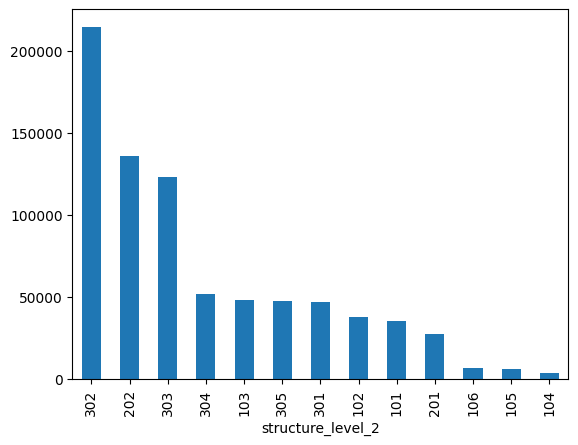

In [59]:
df_A_train.structure_level_2.value_counts().plot(kind='bar');

In [60]:
df_A_train.structure_level_2.value_counts()

structure_level_2
302    214743
202    136000
303    123156
304     51791
103     48486
305     47895
301     46928
102     38084
101     35164
201     27370
106      6627
105      6192
104      3753
Name: count, dtype: int64

In [61]:
# create a different df_A_train and df_B_train where the distribution per structure_level_2 is more or less equal
df_A_train_under = df_A_train.groupby('structure_level_2').sample(n=3500)

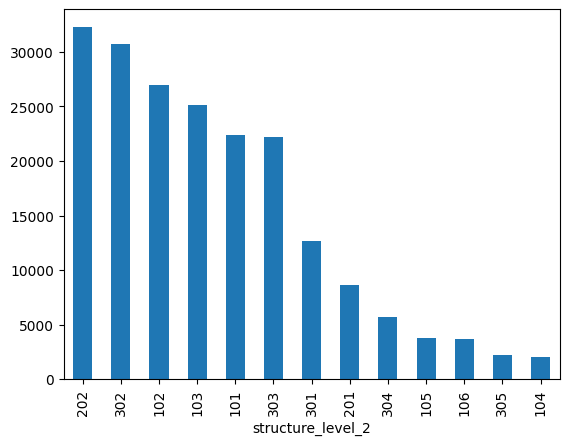

In [62]:
df_B_train.structure_level_2.value_counts().plot(kind='bar');

In [63]:
df_B_train.structure_level_2.value_counts()

structure_level_2
202    32282
302    30749
102    26988
103    25157
101    22342
303    22227
301    12672
201     8628
304     5656
105     3725
106     3692
305     2190
104     1994
Name: count, dtype: int64

In [64]:
df_B_train_under = df_B_train.groupby('structure_level_2').sample(n=1500)

In [65]:
%%timeit -n 1 -r 1

x_columns = ['sku', 'time_key', 'structure_level_2']

pipeline_17 = make_pipeline(
    TransformTimekey(),
    RandomForestRegressor(min_samples_split=5, max_depth=12)
)

# modelling
pipeline_A_rfu, pipeline_B_rfu, dtypes = try_model(df_A_train_under, df_A_val, df_A_test, df_B_train_under, df_B_val, df_B_test, x_columns, 'structure_level_2', pipeline_17)

# simulate the app
response = {"sku": "3547", "time_key": 20250101, 'structure_level_2': 305}
pvp_is_competitorA, pvp_is_competitorB = new_pred(response, x_columns, dtypes, pipeline_A_rfu, pipeline_B_rfu)

Competitor A:
Generally: MAE train 7.013685619875304, val 11.06608843792317, test 9.85976655301367, RMSE train 10.940342657232934, val 16.66610927163334, test 14.915890842715186
Differences: MAE train 11.480157471783356, val 14.309658644193306, test 19.490481801749826, RMSE train 14.175909265682456, val 23.351216179569626, test 31.951548857373403
Competitor B:
Generally: MAE train 2.6879335631999957, val 6.456700058385252, test 7.686026897928042, RMSE train 5.147452587765518, val 14.878792299219564, test 18.76823122448272
Differences: MAE train 6.8644516536926865, val 25.993554084911704, test 35.67750310944296, RMSE train 9.039629158746692, val 48.86501814689671, test 70.89706656998379
Price A: [101.6738602]€, Price B: [77.58801051]€
12.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


### 2.3.3. Oversampling

In [66]:
df_A_train.structure_level_2.value_counts().sum()

np.int64(786189)

In [67]:
786189/13

60476.07692307692

In [68]:
df_A_train_over = df_A_train.groupby('structure_level_2').sample(n=40000, replace=True)

In [69]:
df_B_train.structure_level_2.value_counts().sum()

np.int64(198302)

In [70]:
198302/13

15254.0

In [71]:
df_B_train_over = df_B_train.groupby('structure_level_2').sample(n=10000, replace=True)

In [72]:
%%timeit -n 1 -r 1

x_columns = ['sku', 'time_key', 'structure_level_2']

pipeline_18 = make_pipeline(
    TransformTimekey(),
    RandomForestRegressor(min_samples_split=5, max_depth=12)
)

# modelling
pipeline_A_rfo, pipeline_B_rfo, dtypes = try_model(df_A_train_over, df_A_val, df_A_test, df_B_train_over, df_B_val, df_B_test, x_columns, 'structure_level_2', pipeline_18)

# simulate the app
response = {"sku": "3547", "time_key": 20250101, 'structure_level_2': 305}
pvp_is_competitorA, pvp_is_competitorB = new_pred(response, x_columns, dtypes, pipeline_A_rfo, pipeline_B_rfo)

Competitor A:
Generally: MAE train 7.357688335213415, val 10.936208568265876, test 10.153038609433422, RMSE train 11.877616584471188, val 16.247695246020534, test 15.641178260716101
Differences: MAE train 12.798630969733988, val 14.988356574718072, test 25.640423289244318, RMSE train 16.027274930662365, val 24.02830373782129, test 36.42532675530559
Competitor B:
Generally: MAE train 2.7876459982585122, val 6.354575909629932, test 7.266435907333146, RMSE train 5.577753161785074, val 14.946803944882435, test 17.960431361957404
Differences: MAE train 8.460495700029517, val 25.51928572438317, test 31.81498558790416, RMSE train 11.995393563138297, val 49.63630220150869, test 68.42727942953499
Price A: [105.22604787]€, Price B: [77.585188]€
1min 14s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Undersampling and oversampling really doesn't seem to help at all... :o

### 2.3.4. Normalise Target

In [81]:
# I believe that's possible with TransformedTargetRegressor
# https://stackoverflow.com/questions/18602489/using-a-transformer-estimator-to-transform-the-target-labels-in-sklearn-pipeli
# https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html

# seems that besides fitting the target transformer, the estimator/pipeline needs to be fitted beforehand...

In [73]:
%%timeit -n 1 -r 1

x_columns = ['sku', 'time_key', 'structure_level_2']

pipeline_19 = make_pipeline(
    TransformTimekey(),
    TransformedTargetRegressor(regressor=RandomForestRegressor(min_samples_split=5, max_depth=12), transformer=StandardScaler())
)

# modelling
pipeline_A_tt, pipeline_B_tt, dtypes = try_model(df_A_train, df_A_val, df_A_test, df_B_train, df_B_val, df_B_test, x_columns, 'structure_level_2', pipeline_19)

# simulate the app
response = {"sku": "3547", "time_key": 20250101, 'structure_level_2': 305}
pvp_is_competitorA, pvp_is_competitorB = new_pred(response, x_columns, dtypes, pipeline_A_tt, pipeline_B_tt)

Competitor A:
Generally: MAE train 9.71210810603694, val 10.914591429764304, test 9.749261818598772, RMSE train 14.223657089008862, val 16.127048289851068, test 15.00059709993761
Differences: MAE train 9.240231956882225, val 11.501839766629804, test 23.94431123260766, RMSE train 12.470315079600269, val 19.34218101923043, test 35.72653327561879
Competitor B:
Generally: MAE train 3.037514850183337, val 5.611032586021252, test 6.443769886204913, RMSE train 5.659530790190739, val 14.119695327605715, test 17.0578312404141
Differences: MAE train 6.863217371396168, val 24.870939229517454, test 31.54035410248327, RMSE train 9.795694306483174, val 47.592677108237815, test 68.1699996616661
Price A: [100.03056421]€, Price B: [77.58561386]€
2min 3s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Doesn't change much either...

### 2.3.5. Hyperparameter search

In [74]:
# scores: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-callable
# nothing about mae or rmse...

In [75]:
grid_search_parameter_space = { 'max_depth': range(10, 14),
                                'min_samples_split': range(3, 6) }

scorers = {'mae_scorer': make_scorer(mean_absolute_error),
           'rmse_scorer': make_scorer(root_mean_squared_error)}

In [77]:
x_columns = ['sku', 'time_key', 'structure_level_2']

grid_search_A = GridSearchCV( RandomForestRegressor(),
                              grid_search_parameter_space,
                              scoring=scorers,
                              return_train_score=True,
                              refit='mae_scorer' )

pipeline_grid_A = make_pipeline( TransformTimekey(),
                                 grid_search_A )

In [78]:
pipeline_grid_A = prep_fit(df_A_train, df_A_val, df_A_test, x_columns, pipeline_grid_A)

In [79]:
grid_results_A = pd.DataFrame(grid_search_A.cv_results_).sort_values(by="rank_test_mae_scorer")

In [80]:
grid_results_A[['mean_fit_time', 'param_max_depth', 'param_min_samples_split', 'rank_test_mae_scorer', 'mean_test_mae_scorer', 'mean_train_mae_scorer', 'rank_test_rmse_scorer', 'mean_test_rmse_scorer', 'mean_train_rmse_scorer']]

,mean_fit_time,param_max_depth,param_min_samples_split,rank_test_mae_scorer,mean_test_mae_scorer,mean_train_mae_scorer,rank_test_rmse_scorer,mean_test_rmse_scorer,mean_train_rmse_scorer
1,340.597729,10,4,1,13.390256,12.639533,1,20.796115,18.604816
2,81.887373,10,5,2,13.369750,12.623361,2,20.729269,18.548849
0,56.868600,10,3,3,13.363528,12.610500,3,20.723050,18.498261
4,62.395002,11,4,4,12.022152,11.169633,4,18.665215,16.367755
5,62.315255,11,5,5,12.012198,11.159591,5,18.665061,16.370153
3,63.879639,11,3,6,11.988105,11.135220,6,18.602250,16.293871
7,66.482267,12,4,7,10.661394,9.735445,7,17.017103,14.470061
8,65.961269,12,5,8,10.643518,9.722230,8,16.977800,14.433821
6,67.397648,12,3,9,10.627558,9.699982,9,16.946246,14.379629
10,70.462287,13,4,10,9.525292,8.458013,10,15.799194,12.910391


In [81]:
grid_search_B = GridSearchCV( RandomForestRegressor(),
                              grid_search_parameter_space,
                              scoring=scorers,
                              return_train_score=True,
                              refit='mae_scorer' )

pipeline_grid_B = make_pipeline( TransformTimekey(),
                                 grid_search_B )

In [82]:
pipeline_grid_B = prep_fit(df_B_train, df_B_val, df_B_test, x_columns, pipeline_grid_B)

In [83]:
grid_results_B = pd.DataFrame(grid_search_B.cv_results_).sort_values(by="rank_test_mae_scorer")

In [84]:
grid_results_B[['mean_fit_time', 'param_max_depth', 'param_min_samples_split', 'rank_test_mae_scorer', 'mean_test_mae_scorer', 'mean_train_mae_scorer', 'rank_test_rmse_scorer', 'mean_test_rmse_scorer', 'mean_train_rmse_scorer']]

,mean_fit_time,param_max_depth,param_min_samples_split,rank_test_mae_scorer,mean_test_mae_scorer,mean_train_mae_scorer,rank_test_rmse_scorer,mean_test_rmse_scorer,mean_train_rmse_scorer
0,12.417165,10,3,1,6.598694,5.303642,2,13.586297,8.338276
1,12.343147,10,4,2,6.572843,5.296702,3,13.572620,8.343468
2,12.344108,10,5,3,6.570122,5.283051,1,13.614793,8.306615
5,13.345430,11,5,4,5.496289,4.027448,5,12.764255,6.680202
3,13.336010,11,3,5,5.490302,4.024664,4,12.766809,6.679274
4,13.382146,11,4,6,5.484921,4.018250,6,12.710982,6.669583
6,14.309019,12,3,7,4.660530,2.993513,7,12.302008,5.366350
7,14.288985,12,4,8,4.631448,2.973319,8,12.230677,5.352365
8,14.335276,12,5,9,4.615634,2.967801,9,12.197976,5.347809
9,15.196264,13,3,10,3.983888,2.167563,10,11.816411,4.285728


In [85]:
grid_results_A[['mean_fit_time', 'param_max_depth', 'param_min_samples_split', 'rank_test_mae_scorer', 'mean_test_mae_scorer', 'mean_train_mae_scorer', 'rank_test_rmse_scorer', 'mean_test_rmse_scorer', 'mean_train_rmse_scorer']].to_csv("grid_results_A.csv")

In [86]:
grid_results_B[['mean_fit_time', 'param_max_depth', 'param_min_samples_split', 'rank_test_mae_scorer', 'mean_test_mae_scorer', 'mean_train_mae_scorer', 'rank_test_rmse_scorer', 'mean_test_rmse_scorer', 'mean_train_rmse_scorer']].to_csv("grid_results_B.csv")

# 3. Serialise

In [87]:
with open("columns.json", 'w') as in_fd:
    json.dump(['sku', 'time_key', 'structure_level_2'], in_fd)

In [93]:
with open("dtypes.pickle", 'wb') as in_fd:
    pickle.dump(dtypes, in_fd)

In [94]:
joblib.dump(pipeline_A_rf, "pipelineA.pickle")
joblib.dump(pipeline_B_rf, "pipelineB.pickle");